# **Imports**

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
import time
from google.colab import drive
from google.colab.patches import cv2_imshow
from IPython.display import Audio
from matplotlib import pyplot as plt


import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import iplot
import plotly.express as px
from PIL import Image
import requests
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings("ignore")

#Mount Google Drive
drive.mount('/content/drive')

folder_path = "drive/MyDrive/Book-recommendation/"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Google-Drive Dataset Paths**

In [2]:
books = pd.read_csv(folder_path+'Books.csv')
users = pd.read_csv(folder_path+'Users.csv')
ratings = pd.read_csv(folder_path+'Ratings.csv')

# **Exploratory data analysis**

In [37]:
def eda(dataset,name):
  display(dataset.head(2))
  print("_"*240)
  print(f"{name} dataset has {dataset.shape[0]} nrows and {dataset.shape[1]} ncolumns")
  print("_"*240)
  print(f"{name} dataset has {sum(dataset.isnull().sum().values)} null values")
  print("_"*240)
  display(dataset.info(verbose=True))
  print("_"*240)
  display(dataset.describe(include='all'))
  print("_"*240)
  print(f"number of unique values in each column in the {name} dataset: \n {dataset.nunique()}")



def plot_top20(df, column, title, x_label, y_label, top=20, template='plotly_dark'):

    pl = df[column].value_counts().head(top)
    fig = px.bar(y=pl.values,
                 x=pl.index,
                 color_discrete_sequence=px.colors.sequential.PuBuGn,
                 text=pl.values,
                 title=title,
                 template=template)
    fig.update_layout(
        xaxis_title=x_label,
        yaxis_title=y_label,
        font=dict(size=15, family="Franklin Gothic"))

    # Create a list of tick values and tick text for all bars
    tick_values = list(pl.index)
    tick_text = [str(year) for year in tick_values]

    # Add year labels below each bar
    fig.update_xaxes(
        tickvals=tick_values,
        ticktext=tick_text,
        tickmode='array',
        tickangle=-45)

    fig.show()

def plot_top20_author(df,combined_df):
    authors_top20 = df['Book-Author'].value_counts().head(20)
    authors_top20 = list(authors_top20.index)

    top20_authors = pd.DataFrame(columns = combined_df.columns)

    for author in authors_top20:

        cond_df = combined_df[combined_df['Book-Author'] == author]

        top20_authors =  pd.concat([top20_authors, cond_df], axis=0)
    top20_author = top20_authors[top20_authors['Book-Rating'] != 0]
    top20_author = top20_author.groupby('Book-Author')['Book-Rating'].agg('mean').reset_index().sort_values(by='Book-Rating', ascending=False)
    top20_author
    fig = px.bar(y=top20_author['Book-Rating'],
                x=top20_author['Book-Author'],
                color_discrete_sequence=px.colors.sequential.PuBuGn,
                text=round(top20_author['Book-Rating'],2),
                title= "Average ratings of the books of the Top 20 authors",
                template= 'plotly_dark')
    fig.update_layout(
        xaxis_title="author name",
        yaxis_title="average rating",
        font = dict(size=15,family="Franklin Gothic"))
    fig.show()

def cat_summary_with_graph(dataframe, col_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentages'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=15),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors,
                                     line=dict(color='#DBE6EC',
                                               width=1))),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=10),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)

colors = ['#494BD3', '#E28AE2', '#F1F481', '#79DB80', '#DF5F5F',
              '#69DADE', '#C2E37D', '#E26580', '#D39F49', '#B96FE3']


def plot_yearly_count(df):
    year_count=df['Year-Of-Publication'].value_counts()
    year_count=pd.DataFrame(year_count)

    plt.figure(figsize=(10, 9))
    sns.lineplot(data=year_count)
    plt.title('Year of Publication count (1950 - 2010)')
    plt.xlim(1950, 2011)
    plt.xlabel('Year')
    plt.ylabel('Total Books Published')
    plt.show()

def prGreen(skk): print("\033[92m {}\033[00m" .format(skk))
def prRed(skk): print("\033[91m {}\033[00m" .format(skk))
def prYellow(skk): print("\033[93m {}\033[00m" .format(skk))

def popular_books():

    for (book, ratings) in zip(top10_books['Book-Title'], top10_books['Book-Rating']):
        prGreen(book)
        print("Rating",end='->')
        prRed(round(ratings,1))
        print("-"*50)

def top_books(df):

  books_top20 = df['Book-Title'].value_counts().head(20)
  books_top20 = list(books_top20.index)

  top20_books = pd.DataFrame(columns = df.columns)

  for book in books_top20:

      cond_df = df[df['Book-Title'] == book]

      top20_books =  pd.concat([top20_books, cond_df], axis=0)


  top20_books = top20_books[top20_books['Book-Rating'] != 0]
  top20_books = top20_books.groupby('Book-Title')['Book-Rating'].agg('mean').reset_index().sort_values(by='Book-Rating', ascending=False)

  return top20_books



### ***Books***

In [4]:
eda(books,name="Books")

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Books dataset has 271360 nrows and 8 ncolumns
________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Books dataset has 6 null values
________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               -------------

None

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271359,271360,271358,271360,271360,271357
unique,271360,242135,102023,202,16807,271044,271044,271041
top,0195153448,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/225307649X.0...
freq,1,27,632,13903,7535,2,2,2


________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
number of unique values in each column in the Books dataset: 
 ISBN                   271360
Book-Title             242135
Book-Author            102023
Year-Of-Publication       202
Publisher               16807
Image-URL-S            271044
Image-URL-M            271044
Image-URL-L            271041
dtype: int64


In [50]:
pd.DataFrame(df['Book-Title'].value_counts())

,Book-Title
The Lovely Bones: A Novel,707
Wild Animus,581
The Da Vinci Code,494
The Secret Life of Bees,406
The Nanny Diaries: A Novel,393
...,...
Dream Traveler,1
Goofy Foot : An Alex Rasmussen Mystery (Alex Rasmussen Series),1
Midnighters #1: The Secret Hour (Midnighters),1
A Fugue in Hell's Kitchen: A Katy Green Mystery,1


### ***Users***

In [5]:
eda(users,name="Users")

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0


________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Users dataset has 278858 nrows and 3 ncolumns
________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Users dataset has 110762 null values
________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0  

None

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________


,User-ID,Location,Age
count,278858.00000,278858,168096.000000
unique,NaN,57339,NaN
top,NaN,"london, england, united kingdom",NaN
freq,NaN,2506,NaN
mean,139429.50000,NaN,34.751434
std,80499.51502,NaN,14.428097
min,1.00000,NaN,0.000000
25%,69715.25000,NaN,24.000000
50%,139429.50000,NaN,32.000000
75%,209143.75000,NaN,44.000000


________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
number of unique values in each column in the Users dataset: 
 User-ID     278858
Location     57339
Age            165
dtype: int64


### ***Ratings***

In [6]:
eda(ratings,name="Ratings")

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5


________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Ratings dataset has 1149780 nrows and 3 ncolumns
________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Ratings dataset has 0 null values
________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ---

None

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________


,User-ID,ISBN,Book-Rating
count,1.149780e+06,1149780,1.149780e+06
unique,NaN,340556,NaN
top,NaN,0971880107,NaN
freq,NaN,2502,NaN
mean,1.403864e+05,NaN,2.866950e+00
std,8.056228e+04,NaN,3.854184e+00
min,2.000000e+00,NaN,0.000000e+00
25%,7.034500e+04,NaN,0.000000e+00
50%,1.410100e+05,NaN,0.000000e+00
75%,2.110280e+05,NaN,7.000000e+00


________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
number of unique values in each column in the Ratings dataset: 
 User-ID        105283
ISBN           340556
Book-Rating        11
dtype: int64


## **Data Transformation**

In [7]:
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')
books['Year-Of-Publication'].fillna(2000, inplace=True)
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype('int32')
books['Image-URL-M'] = books['Image-URL-M'].str.replace('http://', 'https://')

## **Combining all dataframes into single dataframes**

In [8]:
combined_df = pd.merge(books, ratings, on='ISBN')
combined_df.dropna(inplace=True)

combined_df = pd.merge(combined_df, users, on='User-ID')

# combined_df = combined_df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

## **Plots**

In [9]:
plot_top20(books, 'Year-Of-Publication', 'Top 20 years in which books were published in terms of count', "Year", "Count")

In [10]:
plot_top20(books, 'Book-Author', "Top 20 Authors authored books by count", "Author name", "Count")

In [11]:
plot_top20(books, 'Publisher', "Top 20 Publishers who have published books", "Publisher name", "Count")

In [12]:
plot_top20_author(books,combined_df)

In [41]:
df = combined_df[combined_df['Book-Rating'] != 0]
top20_books = top_books(df)
top10_books = top20_books.head(10)
plot_top20(df, 'Book-Title', "Most Rated Books by Users", "Book Title", "Number of ratings")

In [14]:
cat_summary_with_graph(combined_df, 'Book-Rating')

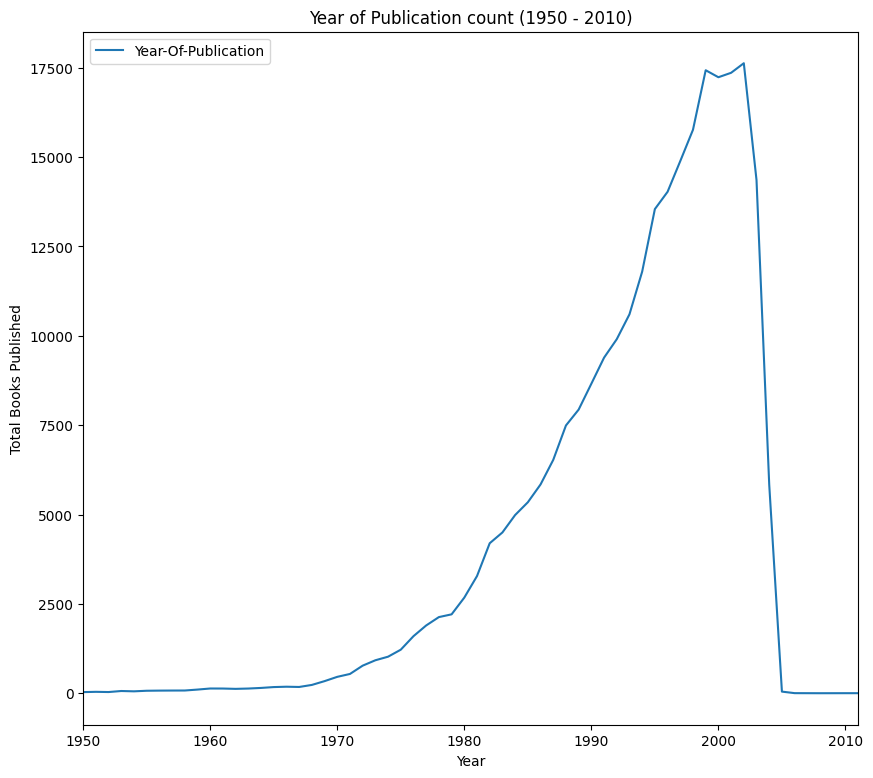

In [15]:
plot_yearly_count(books)

## Popularity Based Recommender System

In [16]:
num_rating_df = combined_df.groupby('Book-Title').count()['Book-Rating'].reset_index()
num_rating_df.rename(columns={'Book-Rating':'num_ratings'},inplace=True)
num_rating_df

,Book-Title,num_ratings
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1
...,...,...
241061,Ã?Â?lpiraten.,2
241062,Ã?Â?rger mit Produkt X. Roman.,4
241063,Ã?Â?sterlich leben.,1
241064,Ã?Â?stlich der Berge.,3


In [17]:
avg_rating_df = combined_df.groupby('Book-Title').mean()['Book-Rating'].reset_index()
avg_rating_df.rename(columns={'Book-Rating':'avg_rating'},inplace=True)
avg_rating_df

,Book-Title,avg_rating
0,A Light in the Storm: The Civil War Diary of ...,2.250000
1,Always Have Popsicles,0.000000
2,Apple Magic (The Collector's series),0.000000
3,"Ask Lily (Young Women of Faith: Lily Series, ...",8.000000
4,Beyond IBM: Leadership Marketing and Finance ...,0.000000
...,...,...
241061,Ã?Â?lpiraten.,0.000000
241062,Ã?Â?rger mit Produkt X. Roman.,5.250000
241063,Ã?Â?sterlich leben.,7.000000
241064,Ã?Â?stlich der Berge.,2.666667


In [18]:
popularity_based_recommender_system = num_rating_df.merge(avg_rating_df,on='Book-Title')
popularity_based_recommender_system

,Book-Title,num_ratings,avg_rating
0,A Light in the Storm: The Civil War Diary of ...,4,2.250000
1,Always Have Popsicles,1,0.000000
2,Apple Magic (The Collector's series),1,0.000000
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1,8.000000
4,Beyond IBM: Leadership Marketing and Finance ...,1,0.000000
...,...,...,...
241061,Ã?Â?lpiraten.,2,0.000000
241062,Ã?Â?rger mit Produkt X. Roman.,4,5.250000
241063,Ã?Â?sterlich leben.,1,7.000000
241064,Ã?Â?stlich der Berge.,3,2.666667


In [19]:
popularity_based_recommender_system = popularity_based_recommender_system[popularity_based_recommender_system['num_ratings']>=250].sort_values('avg_rating',ascending=False).head(50)
popularity_based_recommender_system = popularity_based_recommender_system.merge(books,on='Book-Title').drop_duplicates('Book-Title')[['Book-Title','Book-Author','Image-URL-M','num_ratings','avg_rating']]

In [20]:
# df[df['Book-Title']=="Harry Potter and the Prisoner of Azkaban (Book 3)"]['Book-Rating'].count()

In [21]:
popularity_based_recommender_system

,Book-Title,Book-Author,Image-URL-M,num_ratings,avg_rating
0,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,https://images.amazon.com/images/P/0439136350....,428,5.852804
3,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,https://images.amazon.com/images/P/0439139597....,387,5.824289
5,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,https://images.amazon.com/images/P/0590353403....,278,5.737410
9,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,https://images.amazon.com/images/P/043935806X....,347,5.501441
13,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,https://images.amazon.com/images/P/0439064872....,556,5.183453
16,The Hobbit : The Enchanting Prelude to The Lor...,J.R.R. TOLKIEN,https://images.amazon.com/images/P/0345339681....,281,5.007117
17,The Fellowship of the Ring (The Lord of the Ri...,J.R.R. TOLKIEN,https://images.amazon.com/images/P/0345339703....,368,4.948370
26,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,https://images.amazon.com/images/P/059035342X....,575,4.895652
28,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN,https://images.amazon.com/images/P/0345339711....,260,4.880769
39,To Kill a Mockingbird,Harper Lee,https://images.amazon.com/images/P/0446310786....,510,4.700000


# **Collaborative Filtering Based Recommender System**
The two most popular forms of collaborative filtering are:


**User Based:** Here, we look for the users who have rated various items in the same way and then find the rating of the missing item with the help of these users.

**Item Based:** Here, we explore the relationship between the pair of items (the user who bought Y, also bought Z). We find the missing rating with the help of the ratings given to the other items by the user.

## **Item Based Collaborative Filtering**

We are going to count the rating of books to classify the common and rare ones

In [22]:
count_rate = pd.DataFrame(combined_df[combined_df['Book-Rating'] != 0]['Book-Title'].value_counts())
count_rate.head()

,Book-Title
The Lovely Bones: A Novel,707
Wild Animus,581
The Da Vinci Code,494
The Secret Life of Bees,406
The Nanny Diaries: A Novel,393


So we are going to classify the rare books as the books who got rated 100 or less times

In [23]:
rare_books=count_rate[count_rate["Book-Title"]<=100].index
rare_books[:5]

Index(['Cause of Death', 'Night', 'Deception Point', 'Disclosure',
       'The Queen of the Damned (Vampire Chronicles (Paperback))'],
      dtype='object')

So if the book is not included in the rare books we are going to classify it as common one

In [24]:
common_books=combined_df[combined_df['Book-Rating'] != 0][~combined_df[combined_df['Book-Rating'] != 0]["Book-Title"].isin(rare_books)]
common_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age
19,0786868716,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion,http://images.amazon.com/images/P/0786868716.0...,https://images.amazon.com/images/P/0786868716....,http://images.amazon.com/images/P/0786868716.0...,11400,9,"ottawa, ontario, canada",49.0
20,0151008116,Life of Pi,Yann Martel,2002,Harcourt,http://images.amazon.com/images/P/0151008116.0...,https://images.amazon.com/images/P/0151008116....,http://images.amazon.com/images/P/0151008116.0...,11400,6,"ottawa, ontario, canada",49.0
22,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,https://images.amazon.com/images/P/0312195516....,http://images.amazon.com/images/P/0312195516.0...,11400,7,"ottawa, ontario, canada",49.0
27,0743418174,Good in Bed,Jennifer Weiner,2002,Washington Square Press,http://images.amazon.com/images/P/0743418174.0...,https://images.amazon.com/images/P/0743418174....,http://images.amazon.com/images/P/0743418174.0...,11400,8,"ottawa, ontario, canada",49.0
37,0440222656,The Horse Whisperer,Nicholas Evans,1996,Dell,http://images.amazon.com/images/P/0440222656.0...,https://images.amazon.com/images/P/0440222656....,http://images.amazon.com/images/P/0440222656.0...,11400,6,"ottawa, ontario, canada",49.0


Now lets make recommendation if the book is common.

First lets create dataframe which its index is the Users IDs and the columns are the books titles and the values are the rating of the user to that book.

In [25]:
item_based_cb = common_books.pivot_table(index=["User-ID"],columns=["Book-Title"],values="Book-Rating")

Lets now assume a book title and see what recommendation we can make -

The corrwith function in Pandas computes pair-wise correlations between rows and columns of a dataframe with rows and columns of a series or dataframe. Rows and columns of the dataframe and the other object are first matched before computing the correlations.

*Now we are creating recommendation df with the corrwith function*

**Correlation Calculation:**

For each book in item_based_cb, the method computes the correlation (e.g., Pearson correlation coefficient) between the similarity vector of 'Me Talk Pretty One Day' and the similarity vector of that particular book.

In [26]:
book_title = 'Me Talk Pretty One Day'
sim = item_based_cb[book_title]
recommendation_df=pd.DataFrame(item_based_cb.corrwith(sim).sort_values(ascending=False)).reset_index(drop=False)
recommendation_df

,Book-Title,0
0,Me Talk Pretty One Day,1.0
1,Left Behind: A Novel of the Earth's Last Days ...,1.0
2,"A Child Called \It\"": One Child's Courage to S...",1.0
3,Lord of the Flies,1.0
4,The Chamber,1.0
...,...,...
187,The Rescue,NaN
188,"The Return of the King (The Lord of the Rings,...",NaN
189,The Smoke Jumper,NaN
190,When the Wind Blows,NaN


Lets check if the book the user choosen is included in the recommendation df or not, bec if it is included we don't want to recommend it so we will make sure to drop it

In [27]:
if not recommendation_df['Book-Title'][recommendation_df['Book-Title'] == book_title].empty:
    recommendation_df=recommendation_df.drop(recommendation_df[recommendation_df["Book-Title"]==book_title].index[0])

**Lets now collect the books with less ratings (which its average rating is less than 5)**

In [28]:
less_rating=[]
for i in recommendation_df["Book-Title"]:
    if df[df["Book-Title"]==i]["Book-Rating"].mean() < 5:
        less_rating.append(i)

less_rating

['Wild Animus']

**Lets make sure to rank the highly rated books**

In [29]:
if recommendation_df.shape[0] - len(less_rating) > 5:

    recommendation_df=recommendation_df[~recommendation_df["Book-Title"].isin(less_rating)]
    recommendation_df.columns=["Book-Title","Correlation"]


for (candidate_book, corr) in zip(recommendation_df['Book-Title'], recommendation_df['Correlation']):
    corr_thershold = 0.7
    if corr > corr_thershold:
        ratings = df[df['Book-Title'] == candidate_book]['Book-Rating'].mean()
        prGreen(candidate_book)
        print("Rating ", end = '->')
        prRed(round(ratings,1))
        print("-"*50)
    else:
        break

 Left Behind: A Novel of the Earth's Last Days (Left Behind No. 1)
Rating -> 7.7
--------------------------------------------------
 A Child Called \It\": One Child's Courage to Survive"
Rating -> 8.0
--------------------------------------------------
 Lord of the Flies
Rating -> 8.0
--------------------------------------------------
 The Chamber
Rating -> 7.4
--------------------------------------------------
 The Poisonwood Bible: A Novel
Rating -> 8.2
--------------------------------------------------
 The Lost World
Rating -> 7.2
--------------------------------------------------
 Four Blind Mice
Rating -> 8.2
--------------------------------------------------
 It
Rating -> 8.1
--------------------------------------------------
 She's Come Undone (Oprah's Book Club)
Rating -> 7.7
--------------------------------------------------
 While I Was Gone
Rating -> 7.0
--------------------------------------------------
 The Reader
Rating -> 7.2
---------------------------------------------

Now our item based collaborative recommendation system is ready, lets put it all together to bulild our RS

In [30]:
def item_based_coll_rs(book_title):

    book_title = str(book_title)
    if book_title in combined_df['Book-Title'].values:

        count_rate = pd.DataFrame(df['Book-Title'].value_counts())
        rare_books=count_rate[count_rate["Book-Title"]<=100].index

        common_books=df[~df["Book-Title"].isin(rare_books)]

        if book_title in rare_books:
            prYellow("A rare book, so u may try our popular books: \n ")
            popular_books()

        else:

            item_based_cb = common_books.pivot_table(index=["User-ID"],columns=["Book-Title"],values="Book-Rating")
            sim = item_based_cb[book_title]
            recommendation_df=pd.DataFrame(item_based_cb.corrwith(sim).sort_values(ascending=False)).reset_index(drop=False)

            if not recommendation_df['Book-Title'][recommendation_df['Book-Title'] == book_title].empty:
                recommendation_df=recommendation_df.drop(recommendation_df[recommendation_df["Book-Title"]==book_title].index[0])

            less_rating=[]
            for i in recommendation_df["Book-Title"]:
                if df[df["Book-Title"]==i]["Book-Rating"].mean() < 5:
                    less_rating.append(i)

            if recommendation_df.shape[0] - len(less_rating) > 5:

                recommendation_df=recommendation_df[~recommendation_df["Book-Title"].isin(less_rating)]
                recommendation_df.columns=["Book-Title","Correlation"]


            for (candidate_book, corr) in zip(recommendation_df['Book-Title'], recommendation_df['Correlation']):
                corr_thershold = 0.7
                if corr > corr_thershold:
                    ratings = df[df['Book-Title'] == candidate_book]['Book-Rating'].mean()
                    prGreen(candidate_book)
                    print("Rating ", end = '->')
                    prRed(round(ratings,1))
                    print("-"*50)
                else:
                    break

    else:
        prYellow("This book is not in our library, check out our most popular books:")
        print()
        popular_books()

In [38]:
item_based_coll_rs('Me Talk Pretty One Day')

 Left Behind: A Novel of the Earth's Last Days (Left Behind No. 1)
Rating -> 7.7
--------------------------------------------------
 A Child Called \It\": One Child's Courage to Survive"
Rating -> 8.0
--------------------------------------------------
 Lord of the Flies
Rating -> 8.0
--------------------------------------------------
 The Chamber
Rating -> 7.4
--------------------------------------------------
 The Poisonwood Bible: A Novel
Rating -> 8.2
--------------------------------------------------
 The Lost World
Rating -> 7.2
--------------------------------------------------
 Four Blind Mice
Rating -> 8.2
--------------------------------------------------
 It
Rating -> 8.1
--------------------------------------------------
 She's Come Undone (Oprah's Book Club)
Rating -> 7.7
--------------------------------------------------
 While I Was Gone
Rating -> 7.0
--------------------------------------------------
 The Reader
Rating -> 7.2
---------------------------------------------

In [39]:
item_based_coll_rs("From One to One Hundred")

 A rare book, so u may try our popular books: 
 
 Harry Potter and the Prisoner of Azkaban (Book 3)
Rating-> 9.0
--------------------------------------------------
 Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Rating-> 8.9
--------------------------------------------------
 Harry Potter and the Chamber of Secrets (Book 2)
Rating-> 8.8
--------------------------------------------------
 The Secret Life of Bees
Rating-> 8.5
--------------------------------------------------
 The Da Vinci Code
Rating-> 8.4
--------------------------------------------------
 The Lovely Bones: A Novel
Rating-> 8.2
--------------------------------------------------
 The Red Tent (Bestselling Backlist)
Rating-> 8.2
--------------------------------------------------
 Where the Heart Is (Oprah's Book Club (Paperback))
Rating-> 8.1
--------------------------------------------------
 Life of Pi
Rating-> 8.1
--------------------------------------------------
 Angels &amp; Demons
Rating-> 8.0
--

In [33]:
# item_based_coll_rs("Harry Potter and the Prisoner of Azkaban (Book 3)")

In [34]:
# item_based_coll_rs("The Da Vinci Code")

## **User Based Collaborative Filtering**

First we return the active users who have presented in the dataset more than 100 times

In [ ]:
new_df=df[df['User-ID'].map(df['User-ID'].value_counts()) > 100]

In [ ]:
new_df.shape

Lets make our matrix, User as indcies, Books as columns and finally ratings as values

In [ ]:
users_matrix=new_df.pivot_table(index=["User-ID"],columns=["Book-Title"],values="Book-Rating")
users_matrix.head()

return user favorite books

In [ ]:
user_id = 2033 # we assume we want to recommend for that user
users_fav=new_df[new_df["User-ID"]==user_id].sort_values(["Book-Rating"],ascending=False)[0:5]
users_fav.head()

In [ ]:
index=np.where(users_matrix.index==2033)[0][0]
index

Calculate the similarity between the active user and other users

In [ ]:
users_matrix.fillna(0, inplace=True)

u should replace nan values with zero to calculate the similarity

In [ ]:
similarity=cosine_similarity(users_matrix)
similarity[0]

getting users similar to the active user

In [ ]:
similar_users = list(enumerate(similarity[index]))
similar_users[:5]

sort them of course users with high similarity will come first so we can recommend their interest to the active user

In [ ]:
similar_users = sorted(similar_users,key = lambda x:x[1],reverse=True)[1:6]
similar_users

return the user Id for the similar users

In [ ]:
user_rec=[]
for i in similar_users:
        data=df[df["User-ID"]==users_matrix.index[i[0]]]
        user_rec.extend(list(data.drop_duplicates("User-ID")["User-ID"].values))

user_rec

In [ ]:
x=new_df[new_df["User-ID"]==user_id]
recommend_books=[]
user=list(user_rec)
for i in user:
    y=new_df[(new_df["User-ID"]==i)]
    sim_books=y.loc[~y["Book-Title"].isin(x["Book-Title"]),:]
    sim_books=sim_books.sort_values(["Book-Rating"],ascending=False)[0:5]
    recommend_books.extend(sim_books["Book-Title"].values)

recommend_books

Now lets put it all together

In [ ]:
new_df=df[df['User-ID'].map(df['User-ID'].value_counts()) > 100]
users_matrix=new_df.pivot_table(index=["User-ID"],columns=["Book-Title"],values="Book-Rating")
users_matrix.fillna(0, inplace=True)

In [ ]:
def user_based_coll_rs(user_id):

    users_fav=new_df[new_df["User-ID"]==user_id].sort_values(["Book-Rating"],ascending=False)[0:5]

    prYellow("Ypur Top Favorite books: \n")

    for book in users_fav['Book-Title']:

        prGreen(book)
        print("Rating", end='->')
        prRed(round(df[df['Book-Title'] == book]['Book-Rating'].mean(), 2))
        print("-"*50)

    print("\n\n")

    index=np.where(users_matrix.index==2033)[0][0]

    similarity=cosine_similarity(users_matrix)
    similar_users = list(enumerate(similarity[index]))
    similar_users = sorted(similar_users,key = lambda x:x[1],reverse=True)[0:5]

    users_id=[]

    for i in similar_users:

            data=df[df["User-ID"]==users_matrix.index[i[0]]]
            users_id.extend(list(data.drop_duplicates("User-ID")["User-ID"].values))


    x=new_df[new_df["User-ID"]==user_id]
    recommend_books=[]
    user=list(users_id)

    for i in user:

        y=new_df[(new_df["User-ID"]==i)]
        sim_books=y.loc[~y["Book-Title"].isin(x["Book-Title"]),:]
        sim_books=sim_books.sort_values(["Book-Rating"],ascending=False)[0:5]
        recommend_books.extend(sim_books["Book-Title"].values)


    prYellow("Recommended for you: \n")

    for book in recommend_books:
        prGreen(book)
        print("Rating",end='->')
        prRed(round(df[df['Book-Title'] == book]['Book-Rating'].mean(),2))
        print("-"*50)

In [ ]:
# user_based_coll_rs(2033)

In [ ]:
user_based_coll_rs(4385)

In [ ]:
# user_based_coll_rs(31556)

# **Content Based Filtering Recommender System**


In [ ]:
count_rate = pd.DataFrame(df['Book-Title'].value_counts())
rare_books=count_rate[count_rate["Book-Title"]<=200].index
common_books=df[~df["Book-Title"].isin(rare_books)]

common_books.head()

In [ ]:
common_books=common_books.drop_duplicates(subset=["Book-Title"])
common_books.reset_index(inplace=True)
common_books["index"]=[i for i in range(common_books.shape[0])]
common_books.head()

In [ ]:
common_books['Book-Title'] = common_books['Book-Title'].astype('object')
common_books['Book-Author'] = common_books['Book-Author'].astype('object')
common_books['Publisher'] = common_books['Publisher'].astype('object')
targets=["Book-Title","Book-Author","Publisher"]
common_books["all_features"] = [" ".join(common_books[targets].iloc[i,].values) for i in range(common_books[targets].shape[0])]
common_books.head()

In [ ]:
vectorizer=CountVectorizer()
common_booksVector=vectorizer.fit_transform(common_books["all_features"])
similarity=cosine_similarity(common_booksVector)
similarity

**Lets put it all together**

In [ ]:
def content_based(book_title):

    book_title = str(book_title)

    if book_title in combined_df['Book-Title'].values:
        count_rate = pd.DataFrame(combined_df['Book-Title'].value_counts())
        rare_books=count_rate[count_rate["Book-Title"]<=200].index
        common_books=combined_df[~combined_df["Book-Title"].isin(rare_books)]

        if book_title in rare_books:
            prYellow("A rare book, so u may try our popular books: \n ")
            popular_books()

        else:

            common_books=common_books.drop_duplicates(subset=["Book-Title"])
            common_books.reset_index(inplace=True)

            common_books["index"]=[i for i in range(common_books.shape[0])]
            common_books['Book-Title'] = common_books['Book-Title'].astype('object')
            common_books['Book-Author'] = common_books['Book-Author'].astype('object')
            common_books['Publisher'] = common_books['Publisher'].astype('object')

            targets=["Book-Title","Book-Author","Publisher"]
            common_books["all_features"] = [" ".join(common_books[targets].iloc[i,].values) for i in range(common_books[targets].shape[0])]

            vectorizer=CountVectorizer()
            common_booksVector=vectorizer.fit_transform(common_books["all_features"])

            similarity=cosine_similarity(common_booksVector)
            index=common_books[common_books["Book-Title"]==book_title]["index"].values[0]
            similar_books=list(enumerate(similarity[index]))
            similar_booksSorted=sorted(similar_books,key=lambda x:x[1],reverse=True)[1:6]
            r_books=[]

            for i in range(len(similar_booksSorted)):
                r_books.append(common_books[common_books["index"]==similar_booksSorted[i][0]]["Book-Title"].item())

            prYellow(f"Recommend Books similar to {book_title}:\n")
            for book in r_books:
                prGreen(book)
                print("Rating",end='->')
                prRed(round(df[df['Book-Title'] == book]['Book-Rating'].mean(), 2))

    else:
        prYellow("This book is not in our library, check out our most popular books:")
        print()
        popular_books()

In [ ]:
# content_based("The Da Vinci Code")

In [ ]:
# content_based("Clara Callan")

In [ ]:
# content_based('The Mummies of Urumchi')

In [ ]:
pickle.dump(popular_df,open(folder_path+"pkl/"+'popular.pkl','wb'))
pickle.dump(pt,open(folder_path+"pkl/"+'pt.pkl','wb'))
pickle.dump(books,open(folder_path+"pkl/"+'books.pkl','wb'))
pickle.dump(similarity_scores,open(folder_path+"pkl/"+'similarity_scores.pkl','wb'))